# Machine Learning for Predicting if a Protein is Seen
###### By: Marie Andken for ISB

## Setting up Libraries and Data

Imports all necessary libraries 

Downloads the Supplemental Table with all necissary data from: https://raw.githubusercontent.com/HPPProteome/HPP_TargetList/main/lists/Supplemental_table_1.xlsx


In [69]:
#Importing necessary libraries

#Machine Learning Library
import torch

#Data Processing Libraries
import requests
import os
import pandas as pd
from sklearn.utils import resample, shuffle 

#Acuraccy Checking
from sklearn.metrics import accuracy_score

#Plotting Data
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import shap

print("All libraries successfully imported")

# If they didn't, add a cell and run !pip install <library>

All libraries successfully imported


In [70]:
#Downloading data

url = "https://raw.githubusercontent.com/HPPProteome/HPP_TargetList/main/lists/Supplemental_table_1.xlsx"

gene_file = "Supplemental_table_1.xlsx"


if not os.path.exists(gene_file):
    print("Downloading Supplemental Table 1 from GitHub")
    response = requests.get(url)


    if response.status_code == 200:
        with open(gene_file, "wb") as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as '{gene_file}'")
    else:
        print(f"Failed to download file. HTTP status code: {response.status_code}")

else:
    print("Data file found")

Data file found


# Data Preprocessing

## Things to Keep in Mind

### Handling Mixed Data Types
In the downloaded file, `Supplemental_table_1.xlsx`, it is not guaranteed that every row in the same column has the same data type.  
- This inconsistency can lead to errors when converting data into tensors for the model.  
- To avoid such errors, we ensure that each column has consistent data types by applying appropriate conversions or transformations.

### Model Input Expectations
- The current model is performing **binary classification**, which only accepts numerical inputs such as:
    - **Floats**
    - **Integers**
    - **Integer/Float Arrays**

- **String values** cannot be understood by the model and must be converted to numerical representations. For any column with string/word data, we map the values to `0` or `1` where applicable.

### y-Values (Expected Outputs/Labels)
- The model expects the y-values (labels) to be **binary** (`0` or `1`), representing a **yes/no** or **presence/absence** scenario.
- If more than two possible outcomes exist, the model will throw an error.

### Handling NaN Values
- Any NaN values in the dataset can cause the model to return NaN for loss and validation.
- For this reason:
    - NaN values are replaced with `0` in most columns.
    - However, for `protein length`, if the value is missing, we use the `CDS` length.

---

## Data Columns Changed by the Code

### Signal Peptides
The `Signal Peptide` column contains mixed data types:
- **String Values:** If the value is a string (e.g., `"1..#"`), it indicates the presence of a signal peptide. The string typically suggests a range or sequence presence.
- **Float/NaN Values:** A float or NaN indicates that no signal peptide data is available for the gene.

#### In the Code:
- If a **string** is detected, the value is set to `1` to indicate the presence of a signal peptide.
- Otherwise, the value is set to `0` to denote the absence of a signal peptide.
- The entire column is then converted to integers.

### Seen 

`Seen` is a new column created by the code that stores the y-values (expected outputs/labels) for the model.  
It is generated based on the number of `Distinct` peptides associated with each gene.

#### In the Code:
- If `Distinct` is greater than or equal to `2`, the gene is labeled with `1` in the `Seen` column, indicating that the gene has been observed.
- If `Distinct` is less than `2`, the gene is labeled with `0`, meaning the gene is considered unseen.

```python
if row['Distinct'] >= 2:
    gene_data.at[index, 'Seen'] = int(1)  # Mark as seen
else:
    gene_data.at[index, 'Seen'] = int(0)  # Mark as unseen



In [71]:

gene_data = pd.read_excel(gene_file)

# ---- Processing Signal Peptide ----
for index, row in gene_data.iterrows():
    if isinstance(row['Signal Peptide'], str):
        gene_data.at[index, 'Signal Peptide'] = int(1)
    else:
         gene_data.at[index, 'Signal Peptide'] = int(0)
    
    if pd.isna(row['Protein Length']):
        gene_data.at[index, 'Protein Length'] = row['CDS Length']


gene_data['Signal Peptide'] = gene_data['Signal Peptide'].astype(int)


for index, row in gene_data.iterrows():
    if row['Distinct'] >= 2:
        gene_data.at[index, 'Seen'] = int(1)
    elif row['Distinct'] < 2:
        gene_data.at[index, 'Seen'] = int(0)

    else:
        gene_data.at[index, 'Seen'] = int(0)

gene_data['Seen'] = gene_data['Seen'].astype(int)

gene_data.update(gene_data[['Num Transmembrane Regions', 'Highest nTPM Score', 'Tissues with nTPM Score Above 1 (/50)']].fillna(0))

print("Data adjustments complete")

Data adjustments complete


### Data Balancing and Feature Selection

This section of the code ensures that the training data is balanced and prepares the input features (`x_data`) and labels (`y_data`) for the model.

---

### Defining Input Features (`xColumns`)
The `xColumns` list specifies the columns that will be used as input features for the model.  
These features describe various properties of the gene and its associated peptides:
- **Hydrophobicity** – A measure of how hydrophobic the protein is.
- **PI** – The isoelectric point of the protein.
- **protein length** – Length of the protein sequence.
- **Num Transmembrane Regions`** – Number of transmembrane regions in the protein.
- **Signal Peptide** – Presence (`1`) or absence (`0`) of a signal peptide.
- **Highest nTPM Score** – The highest normalized TPM (transcripts per million) (from RNA-Seq data) for the gene.
- **Tissues with nTPM Score Above 1 (/50)** – Number of tissues where the nTPM score is greater than 1.


## Balancing the Dataset
Since the original contains an unequal number of `Seen = 1` and `Seen = 0` values, the dataset is balanced by resampling both classes to the same size.
- We take a smaller sample of the original data set with all the `Seen = 0` values and a random sampling of `Seen = 1`.
- We have less data, but the model doesn't get overtrained on **Seen** proteins and performs more accurately on the test/validation data.
- The data is shuffled so the model doesn't get caught up on the order of the genes and to introduce randomness in the data.



In [72]:

xColumns = ['Hydrophobicity', 'PI', 'Protein Length', 'Num Transmembrane Regions', 'Signal Peptide', 'Highest nTPM Score', 'Tissues with nTPM Score Above 1 (/50)']


pe_0 = gene_data[gene_data['Seen'] == 0]
pe_1 = gene_data[gene_data['Seen'] == 1]


min_size = min(len(pe_0), len(pe_1))
pe_0_balanced = resample(pe_0, replace=False, n_samples=min_size, random_state=42)
pe_1_balanced = resample(pe_1, replace=False, n_samples=min_size, random_state=42)


balanced_gene_data = pd.concat([pe_0_balanced, pe_1_balanced])
balanced_gene_data = shuffle(balanced_gene_data, random_state=42)


x_data = balanced_gene_data[xColumns]
y_data = balanced_gene_data[['Seen']]

print("Balanced X-data:", x_data.shape)
print("Balanced Y-data:", y_data.shape)


Balanced X-data: (2384, 7)
Balanced Y-data: (2384, 1)


## Splitting Data for Training, Validation, and Testing

This section of the code splits the balanced dataset into three subsets:
- **Training Set (`x_train`, `y_train`)** – Used to train the model.
- **Validation Set (`x_val`, `y_val`)** – Used to monitor for overfitting.
- **Test Set (`x_test`, `y_test`)** – Used to evaluate the model’s performance.

---

### Defining Split Sizes
To split the dataset, the total number of rows in `x_data` is divided into:
- **20% for Testing**
- **10% for Validation**
- The remaining **70% for Training** (This should always be the largest)

In [73]:
test_num = int(x_data.shape[0] * 0.2)
val_num = test_num + int(x_data.shape[0] * 0.1) 


x_test = x_data[:test_num]
y_test = y_data[:test_num]
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)


x_val = x_data[test_num:val_num]
y_val = y_data[test_num:val_num]
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

y_train = y_data[val_num:]
x_train = x_data[val_num:]
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)


x_test: (476, 7)
y_test: (476, 1)
x_val: (238, 7)
y_val: (238, 1)
x_train: (1670, 7)
y_train: (1670, 1)


# Model (Binary Classification)

This section defines a deep neural network model for **binary classification** using PyTorch.  
The model takes numerical input features, passes them through multiple layers, and outputs a single value that will be used to predict a binary label (`0` or `1`). 

The output is **not** passed through a `sigmoid` function because the model uses the loss function **`BCEWithLogitsLoss`**.  
As a result:
- The output is **not bounded** between `[0, 1]`.
- Instead, the model produces a **large negative** value to predict `0` and a **large positive** value to predict `1`. 
- Later, when using the model to predict scores, we will run the outputs through a `sigmoid` function.

In [74]:
class BinaryClass(torch.nn.Module):
    def __init__(self, input_dim):
        super(BinaryClass, self).__init__()
        
        self.l1 = torch.nn.Linear(input_dim, 64)
        self.bn1 = torch.nn.BatchNorm1d(64) 
        self.l2 = torch.nn.Linear(64, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.l3 = torch.nn.Linear(128, 256)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.l4 = torch.nn.Linear(256, 128)
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.l5 = torch.nn.Linear(128, 64)
        self.bn5 = torch.nn.BatchNorm1d(64)

        self.l6 = torch.nn.Linear(64, 32)
        self.bn6 = torch.nn.BatchNorm1d(32)
        self.l7 = torch.nn.Linear(32, 1)
        
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, x):
        
        x = torch.nn.functional.relu(self.bn1(self.l1(x)))
        x = self.dropout(x)
        
        x = torch.nn.functional.relu(self.bn2(self.l2(x)))
        x = self.dropout(x)
        
        x = torch.nn.functional.relu(self.bn3(self.l3(x)))
        x = self.dropout(x)
        
        x = torch.nn.functional.relu(self.bn4(self.l4(x)))
        x = self.dropout(x)
        
        x = torch.nn.functional.relu(self.bn5(self.l5(x)))
        x = self.dropout(x)

        x = torch.nn.functional.relu(self.bn6(self.l6(x)))
        x = self.dropout(x)
        
        x = self.l7(x)
        
        return x
print("Model has been defined")

Model has been defined


## Model Parameters

- **Model:**  
  The model is an instance of the `BinaryClass` class, initialized with the number of input features (`x_train.shape[1]`).

- **Learning Rate & Epochs:**  
  - **Learning Rate:** `0.0001`  
    - This controls how much the model adjusts its weights every iteration. 
    - Too high and it can't find a minimum, too low and it can get stuck in a local minimum.

  - **Epochs:** `500`
    - This controls how many times the model looks over the training data. It will assume the data is neew each time. 
    - Data trained on = `epochs * x_data.size[0]`
    - Too many can lead to over fitting (over specialized on training data), not enough can lead to under fitting (no patterns found).

- The higher the number of epochs, the lower you can make your learning rate. With less epochs I suggest a higher learning rate. (change by `0.0001` or `0.00005` each step)

- **Loss Function:**  
  We use **`BCEWithLogitsLoss`**, a binary cross-entropy loss function, with a **positive weight** (`pos_weight`). The `pos_weight` is set to `1` in this case and does nothing, but it can be adjusted if the dataset is imbalanced (e.g., if you have more positive data than negative data). 
  - If you have more positive data (`Seen = 1`), reduce `pos_weight` to `0.8` or `0.5`, so that the model still pays attention to nagative data (`Seen = 0`).

- **Optimizer:**  
  The optimizer used is **Adam**, which is initialized with the model's parameters, the given `learning_rate` and a weight decay of `1e-5` to help with regularization.
  - Do not touch the weight decay, it might not seem all the important, but it helps stop the model from getting caught up in uneccissary trends and overfitting.


In [75]:
model = BinaryClass(x_train.shape[1])

learning_rate = 0.0001
epochs = 400

pos_weight = torch.tensor([1]) #Only change if you have more positive data than negative

loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5)

print("Model initialized and ready to train")


Model initialized and ready to train


#### Conversion to PyTorch Tensors:

- `torch.tensor()` is used to convert the data from a Pandas DataFrame (which is converted to a NumPy array using .to_numpy()) into **PyTorch tensors**.

- The `dtype=torch.float32` ensures that the tensor is of type `float32`, which is necessary for the majority of neural network operations in PyTorch.

- `.reshape(-1, 1)` is applied to the `y-labels` to ensure that they are in the correct **column vector format** for binary classification.


In [76]:
inputs = torch.from_numpy(x_train.to_numpy())
labels =torch.from_numpy(y_train.to_numpy())

inputs = torch.tensor(inputs, dtype=torch.float32) 
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

val_inputs = torch.from_numpy(x_val.to_numpy())
val_labels =torch.from_numpy(y_val.to_numpy())

val_inputs = torch.tensor(val_inputs, dtype=torch.float32) 
val_labels = torch.tensor(val_labels, dtype=torch.float32).reshape(-1, 1)


test_inputs = torch.from_numpy(x_test.to_numpy())
test_labels =torch.from_numpy(y_test.to_numpy())

test_inputs = torch.tensor(test_inputs, dtype=torch.float32) 
test_labels = torch.tensor(test_labels, dtype=torch.float32).reshape(-1, 1)


print(inputs.shape)
print(labels.shape)

torch.Size([1670, 7])
torch.Size([1670, 1])


/var/folders/vw/712ls61922l0ll5ywl4m2g2w0000gn/T/ipykernel_19524/835279709.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/vw/712ls61922l0ll5ywl4m2g2w0000gn/T/ipykernel_19524/835279709.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
/var/folders/vw/712ls61922l0ll5ywl4m2g2w0000gn/T/ipykernel_19524/835279709.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(val_inputs, dtype=t

### Training the Model

This section trains the model, calculates the loss for both the training and validation data, and tracks the performance over multiple epochs. It also evaluates the model's accuracy on the validation data.

---

### Training Loop
The training loop runs for a defined number of epochs. During each epoch, the model undergoes the following steps:

1. **Model Training**:
   - The model's weights are updated based on the training data (`inputs` and `labels`).
   - The optimizer (`Adam`) is used to minimize the loss function, which is `BCEWithLogitsLoss` in this case.
   - Gradients are reset (`optimizer.zero_grad()`), and the model produces output predictions (`outputs = model(inputs)`).
   - The loss is calculated by comparing the model's output to the actual labels (`loss = loss_func(outputs, labels)`), and this loss is added to the `trainLossList` to track performance over time.
   - The model then performs backpropagation (`loss.backward()`) to adjust the weights, and the optimizer updates the weights (`optimizer.step()`).

2. **Model Evaluation**:
   - After each epoch, the model is evaluated on the validation data (`val_inputs` and `val_labels`), and the validation loss is calculated similarly to the training loss.
   - The model's output on the validation set is compared to the actual labels, and accuracy is calculated based on the following logic:
     - If the model output is greater than 0 (indicating class 1), and the true label is also 1, it counts as a correct prediction.
     - If the model output is less than 0 (indicating class 0), and the true label is also 0, it counts as a correct prediction.
   - The accuracy for the validation set is calculated as the ratio of correct predictions to the total number of samples in the validation set.

3. **Tracking Loss and Accuracy**:
   - The training loss (`trainLossList`) and validation loss (`valLossList`) are tracked throughout the training process to monitor the model's progress.
   - Every 20 epochs, the training loss, validation loss, and validation accuracy are printed to provide insight into how the model is performing.

### Signs of Overfitting
   - If your `training loss` is **consistantly lower** than your `validation loss`, your model is overfit. 

---

### Summary of Outputs

At the end of the training process, the final loss and accuracy on the validation set are printed, providing a summary of the model's performance at the last epoch.


In [77]:
trainLossList = []
valLossList = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)

    

    loss = loss_func(outputs, labels)

    
    trainLossList.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        correct = 0
        val_out = model(val_inputs)
        val_loss = loss_func(val_out, val_labels)


        valLossList.append(val_loss.item())

        for i in range(0, len(val_out)):
            if val_out[i] > 0 and val_labels[i] == 1:
                correct += 1

            elif val_out[i] < 0 and val_labels[i] == 0:
                correct += 1

        val_accuracy = correct/len(val_out)

    if epoch % 20 == 0 and epoch != 0:
        print('epoch {}, loss {}, val_loss {}, val_accuracy {}'.format(epoch, loss.item(), val_loss.item(), val_accuracy))
    

print(f'Final: epoch {epoch+1}, loss {loss.item():.4f}, val_loss {val_loss.item():.4f}, val_accuracy {val_accuracy:.4f}')



epoch 20, loss 0.6911333203315735, val_loss 0.6877930164337158, val_accuracy 0.5252100840336135
epoch 40, loss 0.67546546459198, val_loss 0.6835533380508423, val_accuracy 0.5252100840336135
epoch 60, loss 0.6643081307411194, val_loss 0.6817876100540161, val_accuracy 0.5462184873949579
epoch 80, loss 0.6545442938804626, val_loss 0.6793609261512756, val_accuracy 0.5504201680672269
epoch 100, loss 0.6502324938774109, val_loss 0.6717153787612915, val_accuracy 0.5798319327731093
epoch 120, loss 0.6331506967544556, val_loss 0.6543754935264587, val_accuracy 0.6386554621848739
epoch 140, loss 0.6137018203735352, val_loss 0.6291837096214294, val_accuracy 0.6848739495798319
epoch 160, loss 0.5786891579627991, val_loss 0.5872646570205688, val_accuracy 0.7563025210084033
epoch 180, loss 0.5499461889266968, val_loss 0.5209749937057495, val_accuracy 0.8109243697478992
epoch 200, loss 0.5267797708511353, val_loss 0.46671611070632935, val_accuracy 0.8571428571428571
epoch 220, loss 0.4980071783065796,

# Plotting The Model

## Train Loss/Validation Loss v Epochs

- Plots the validation and train loss from all epochs.

- Validation loss should be lower than train loss by the end. If it is not, the model is overfit.

- If your data is limited, average loss will be higher compared to a model with a lot of training and validation data.

- If your validation accuracy starts to even out, that's a sign that you should stop training to higher epochs. If it is still consistantly going down, train it more.

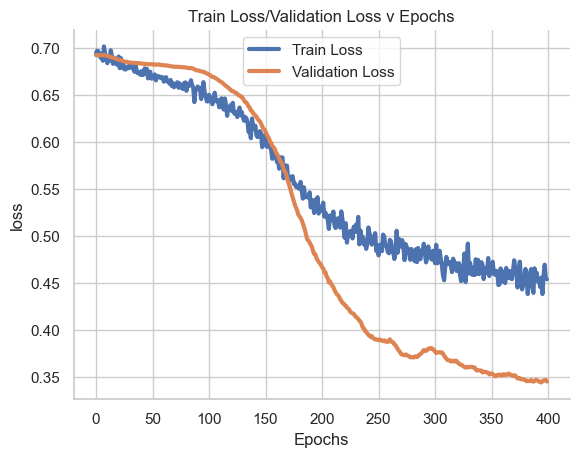

In [78]:
sns.set(style = 'whitegrid', font_scale = 1)

plt.plot(trainLossList, linewidth = 3, label='Train Loss')
plt.plot(valLossList, linewidth = 3, label='Validation Loss')
plt.legend(loc='upper center')
plt.title("Train Loss/Validation Loss v Epochs")
plt.ylabel("loss")
plt.xlabel("Epochs")
sns.despine()

## Accuracy check on Test Set

Evaluates the trained model on the test set and computes the accuracy.

This is a good indication of how your model will perform in the feild.

#### Custom Rounding Function
The `custom_round` function is defined to convert the model's raw output to binary values:
- It uses `torch.where()` to check whether each value in the output tensor is greater than or equal to `0`. If true, it assigns the value `1.0`, otherwise `0.0`. This is used to classify outputs as either `1` (positive class) or `0` (negative class).




In [79]:
def custom_round(tensor):
    return torch.where(tensor >= 0, torch.tensor(1.0), torch.tensor(0.0))

model.eval()
correct = 0
with torch.no_grad():
    outputs = model(test_inputs)
    predicted = custom_round(outputs).squeeze().detach().numpy()

    for i in predicted:
        if i != 1:
            print(i)
            break
    predicted = predicted.astype(int)

    accuracy = accuracy_score(test_labels.numpy(), predicted)
    print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

0.0
Accuracy on Test Set: 88.66%


## SHAP (SHapley Additive exPlanations) for Model Interpretability

In this section, we use SHAP to interpret the model's predictions by analyzing the impact of each feature on the output. SHAP values are computed and visualized to provide insight into how the model makes its predictions.

---

## SHAP Explainer Setup

1. **Model Evaluation Mode**:
   - `model.eval()` ensures that the model is in evaluation mode, disabling features like dropout during inference.

2. **Wrapper Function for SHAP**:
   - `model_wrapper` is a function that converts the input `X` into a tensor, performs a forward pass through the model, and returns the predictions as a NumPy array. This wrapper is used to make the model compatible with SHAP.

3. **SHAP Explainer**:
   - The SHAP explainer is initialized with the `model_wrapper` function and the test inputs (`test_inputs_np`), which are converted from PyTorch tensors to NumPy arrays.
   - The explainer computes the SHAP values, which represent the contribution of each feature to the model’s output for each sample.

4. **SHAP Summary Plot**:
   - `shap.summary_plot()` visualizes the SHAP values for the input features. The plot shows the importance and effect of each feature on the model’s predictions.

---

## How to Read a SHAP Plot

The SHAP summary plot provides a global interpretation of the model's behavior and the significance of each feature in the decision-making process. 

### **Features on the Y-axis**:
   - The features are listed on the Y-axis in descending order of importance (from top to bottom). The higher a feature is in the plot, the greater its impact on the model's predictions.

### **SHAP Values on the X-axis**:
   - The SHAP values along the X-axis represent the contribution of each feature to the model's prediction for each instance. 
   - Positive SHAP values mean that the feature increased the model's likelihood for a positive prediction, while negative values mean the model was more likely to make a negative prediction.

### **Color of the Points**:
   - The color indicates the value of the feature for a particular instance, red (high values) and blue (low values).
   - Indicated how the value of the feature influences the prediction: for example, red (high) values of a feature with high SHAP values will show how large feature values changed the model’s output. 

### **Distribution of SHAP Values**:
   - The distribution of SHAP values for each feature is shown along the X-axis. Wider distributions suggest greater variability in how the feature affects the model’s prediction across different instances.
   
   - Can also show clumping, with low blue values of a feature like `protien length` making the model much more likely to predict that the gene is `Unseen`.
   
### **Feature Importance**:
   - Features at the top of the plot are the most important to the model's predictions, while features further down the plot are less important.


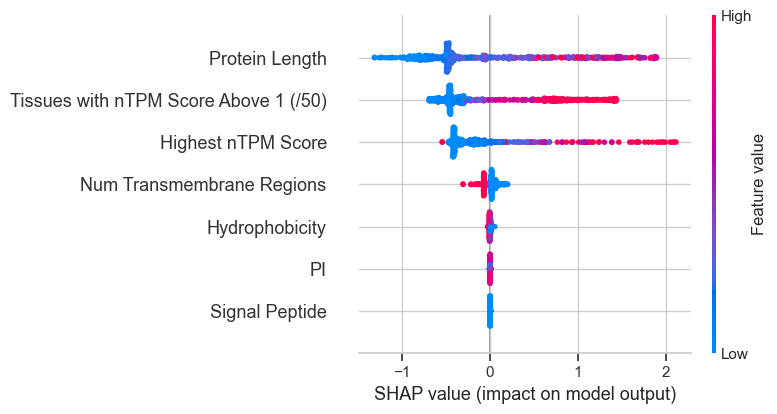

In [80]:
model.eval()

# Define a wrapper function for SHAP
def model_wrapper(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)  
    with torch.no_grad():
        return model(X_tensor).detach().numpy()
    
test_inputs_np = test_inputs.numpy()
explainer = shap.Explainer(model_wrapper, test_inputs_np)

shap_values = explainer(test_inputs_np)

shap.summary_plot(shap_values, test_inputs_np, feature_names=xColumns)

## Using the Model to Make Prediction

`Predict_PE` takes in the information necissary to build a tensor (`x_data `) that the trained model can understand then runs the model on the tensor getting a single output for the single input. 

The output of the model is then passed through a **Sigmoid** function (`torch.sigmoid`) to bound the predicted value between 0 and 1, which represents the probability of the protein being "seen."

 
#### Example Usage

In the example, we define values for a protein and pass them into the `predict_PE` function: (This is used on all proteins in `Supplemental_table_1.xlsx` in the next cell)

```python
hydrophobicity_value = 0.715
PI_value = 8.324
protein_length = 326
num_transmembrane_region = 7
signal_peptide = 1  # 1 means yes, 0 means no
HighnTPM = 0.2
TissuenTPM = 0

predicted_PE = predict_PE(model, hydrophobicity_value, PI_value, protein_length, num_transmembrane_region, signal_peptide, HighnTPM, TissuenTPM)

print(f"Probability of being seen: {predicted_PE}")



In [81]:

def predict_PE(model, hydrophobicity, PI, protein_length, num_transmembrane_region, signal_peptide, HighnTPM, TissuenTPM):
    model.eval() 
    with torch.no_grad():
        input_tensor = torch.tensor([[hydrophobicity, PI, protein_length, num_transmembrane_region, signal_peptide, HighnTPM, TissuenTPM]], dtype=torch.float32)
        output = torch.sigmoid(model(input_tensor))
        return output.item()

hydrophobicity_value = 0.715
PI_value = 8.324
protein_length = 326
num_transmembrane_region = 7
signal_peptide = 1 #1 yes, 0 no
HighnTPM = 0.2
TissuenTPM = 0

predicted_PE = predict_PE(model, hydrophobicity_value, PI_value, protein_length, num_transmembrane_region, signal_peptide, HighnTPM, TissuenTPM)

print(f"Probability of being seen: {predicted_PE}")

Probability of being seen: 0.2151554524898529


## Checking predictions with ROC plots and outputting a table

### New Table

This section adds a column to `Supplemental_table_1.xlsx` called `probability_seen` which gives the models predicted probability that the gene's transcribed protien will be seen. The prediction is made by passing the gene's information through the function `predict_PE` which is explained above.

Makes new table `distinctClassifier.xlsx`. 

---

### Understanding the ROC Curve

The **Receiver Operating Characteristic (ROC)** curve is a graphical representation of a model’s ability to distinguish between two classes, typically **positive** and **negative**. The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings, helping you evaluate the performance of a binary classifier.



#### Key Concepts

1. **True Positive Rate (TPR) / Sensitivity**:
   - Also known as recall, it measures the proportion of actual positive samples that are correctly identified by the model.

2. **False Positive Rate (FPR)**:
   - Measures the proportion of actual negative samples that are incorrectly identified as positive.



#### Interpreting the ROC Curve

- The **x-axis** represents the **False Positive Rate (FPR)**, and the **y-axis** represents the **True Positive Rate (TPR)**.
- The curve represents the performance of the classifier at different thresholds. As you change the decision threshold of the model (for example, from 0.5 to 0.6), the TPR and FPR will change, and this will move along the curve.
- The **diagonal line** (from (0,0) to (1,1)) represents a random classifier, meaning that if your model's ROC curve is near this diagonal, it indicates that the model's performance is no better than random guessing.
- The **area under the curve (AUC)** quantifies the overall performance of the classifier. AUC ranges from 0 to 1:
  - An **AUC of 0.5** means the model has no discriminatory ability, essentially performing randomly.
  - An **AUC of 1** means the model perfectly distinguishes between the classes.
  - The **higher the AUC**, the better the model is at distinguishing between the classes. For example, an AUC of 0.85 means the model has a strong ability to discriminate between the two classes.



#### Example ROC Curve

- **Blue Curve**: This is the actual ROC curve of the model. The closer it is to the top-left corner of the plot (i.e., high TPR and low FPR), the better the model is at classifying positive instances.
- **Gray Diagonal Line**: This line represents a random classifier. If your curve is close to this diagonal, the model isn't performing well.
- **AUC**: The area under the curve is displayed in the legend. A higher AUC value indicates better model performance.



#### Key Takeaways

- **Closer to top-left**: The model is doing well with a high TPR and a low FPR.
- **Closer to the diagonal**: The model's performance is almost as good as random guessing, indicating poor performance.
- **AUC**: The AUC score helps summarize the overall performance of the model. A higher AUC is desirable.

The ROC plot shows how well the trained model can classify the "Seen" vs. "Not Seen" proteins. By analyzing the AUC value in the legend, you can get an overall idea of how well your model is performing.


19433
19433


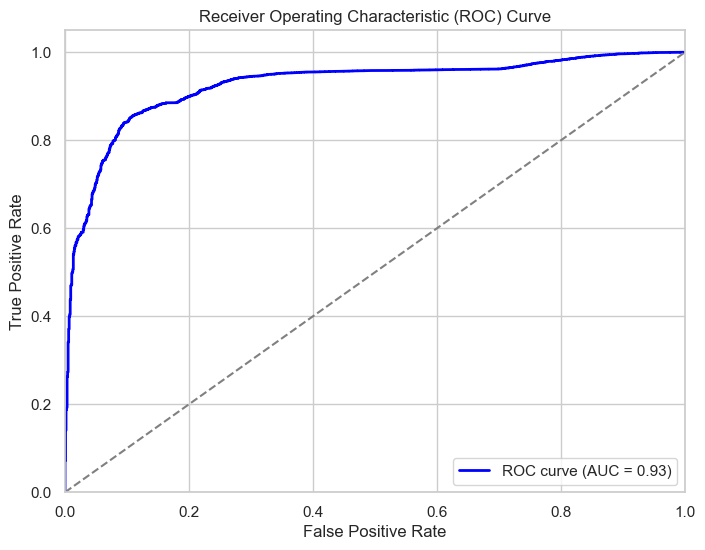

In [82]:
# ['Hydrophobicity', 'PI', 'protein length', 'Num Transmembrane Regions', 'Signal Peptide']

# Scatter plot
indexs = np.array([])
y_true = np.array([])
y_hat = np.array([])

# Histogram
predicted_ones = np.array([])
predicted_notOne = np.array([])

# gene_data[xColumns] = scaler.transform(gene_data[xColumns])

        
for index, row in gene_data.iterrows():
    hydrophobicity_value = row['Hydrophobicity']
    PI_value = row['PI']
    protein_length = row['Protein Length']
    num_transmembrane_region = row['Num Transmembrane Regions']
    signal_peptide = row['Signal Peptide']
    HighnTPM = row['Highest nTPM Score']
    TissuenTPM = row['Tissues with nTPM Score Above 1 (/50)']

    predicted_PE = predict_PE(model, hydrophobicity_value, PI_value, protein_length, num_transmembrane_region, signal_peptide, HighnTPM, TissuenTPM)

    gene_data.at[index, 'probability_seen'] = predicted_PE
    indexs = np.append(indexs, [index])
    y_true = np.append(y_true, [row['Seen']])
    y_hat = np.append(y_hat, [predicted_PE])

    if row['Seen'] == 1:
        predicted_ones = np.append(predicted_ones, [predicted_PE])
    else:
        predicted_notOne = np.append(predicted_notOne, [predicted_PE])

print(len(predicted_notOne)+len(predicted_ones))
print(len(indexs))

# ROC PLOT
fpr, tpr, _ = roc_curve(y_true, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Scatter Plot 

Shows how the predicted probability of a protein corrosponds to its actual `Seen` value.
**Blue**: Protein's seen value.
**Red**: Protein's predicted value.

#### What you should see

- A concentration of blue dots at `0` and the other at `1`
- Two clusters of red, one closer to `0` and the other closer to `1`

If there is no blue dots, the data is being read incorrectly

If the red dots are all concentrated around `0.5`, your model is underfit

If there is only one concetration of red dots near `1` or `0`, the model is overfit

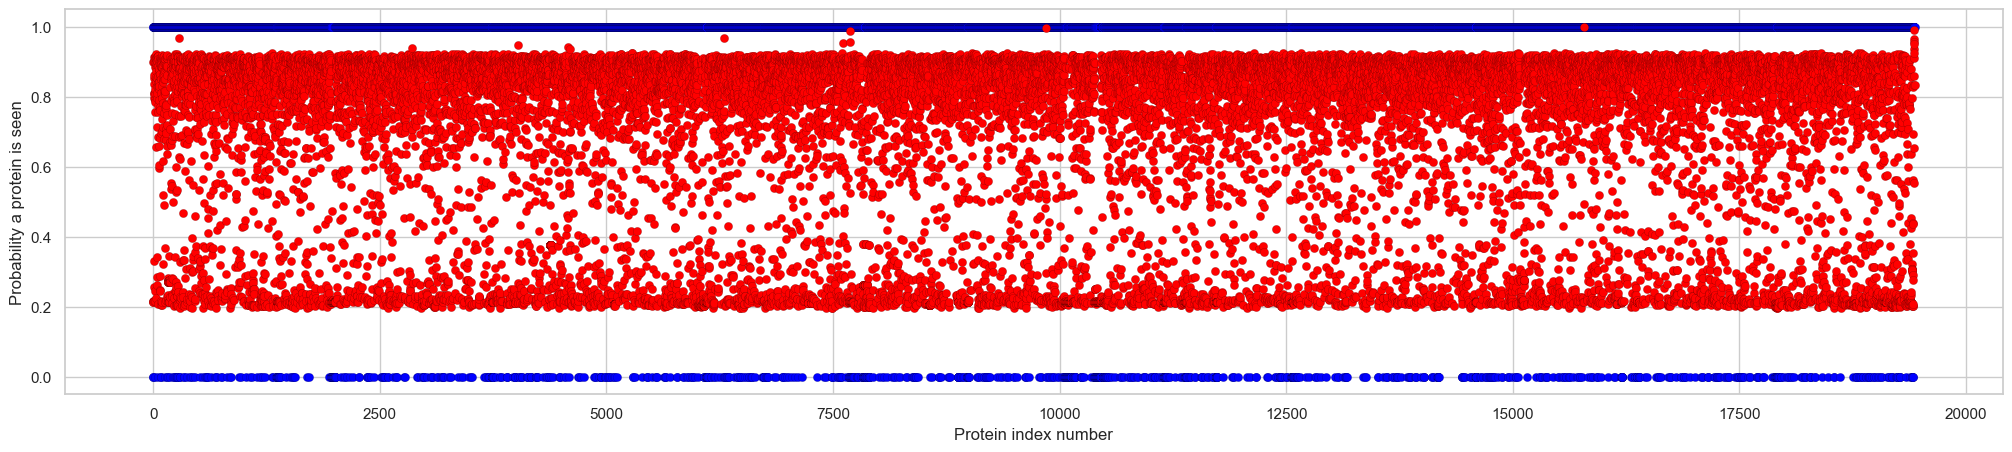

In [83]:
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
plt.plot(indexs, y_true, 'o', color='blue', mec='black', mew=0.1)
plt.plot(indexs, y_hat, 'o', color='red', mec='black', mew=0.1)
plt.ylabel("Probability a protein is seen")
plt.xlabel("Protein index number")

plt.show()

## P-plot

Shows the distributions of predicted probabilities for known **Seen** and **Unseen** proteins.

Blue: Known Seen

Red: Known Unseen

#### Goal

- Should show most red protiens being close to `0` as the model should be predicting them as `0` or `Seen`
- Should show most blue protiens being close `1` as the model should be predicting them as `1` or `Seen`

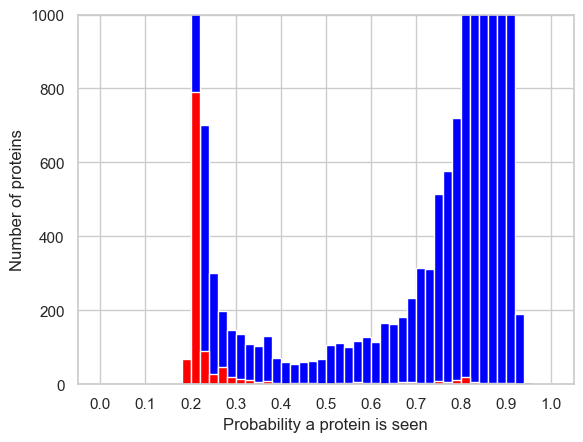

In [84]:
bin_edges = np.arange(0, 1.1, 0.1)
y_edges = np.arange(0, 1000, 100)

plt.hist(predicted_ones, range=[0,1], bins=50, color="blue")
plt.hist(predicted_notOne, range=[0,1], bins=50, color="red")
plt.xticks(bin_edges)
plt.ylim(0, 1000)
plt.xlabel("Probability a protein is seen")
plt.ylabel("Number of proteins")

plt.show()

In [85]:
gene_data.to_excel("distinctClassifier.xlsx", index=False)

## Downloading the data

Follow these steps to download the predicted data to your computer after running the cell:

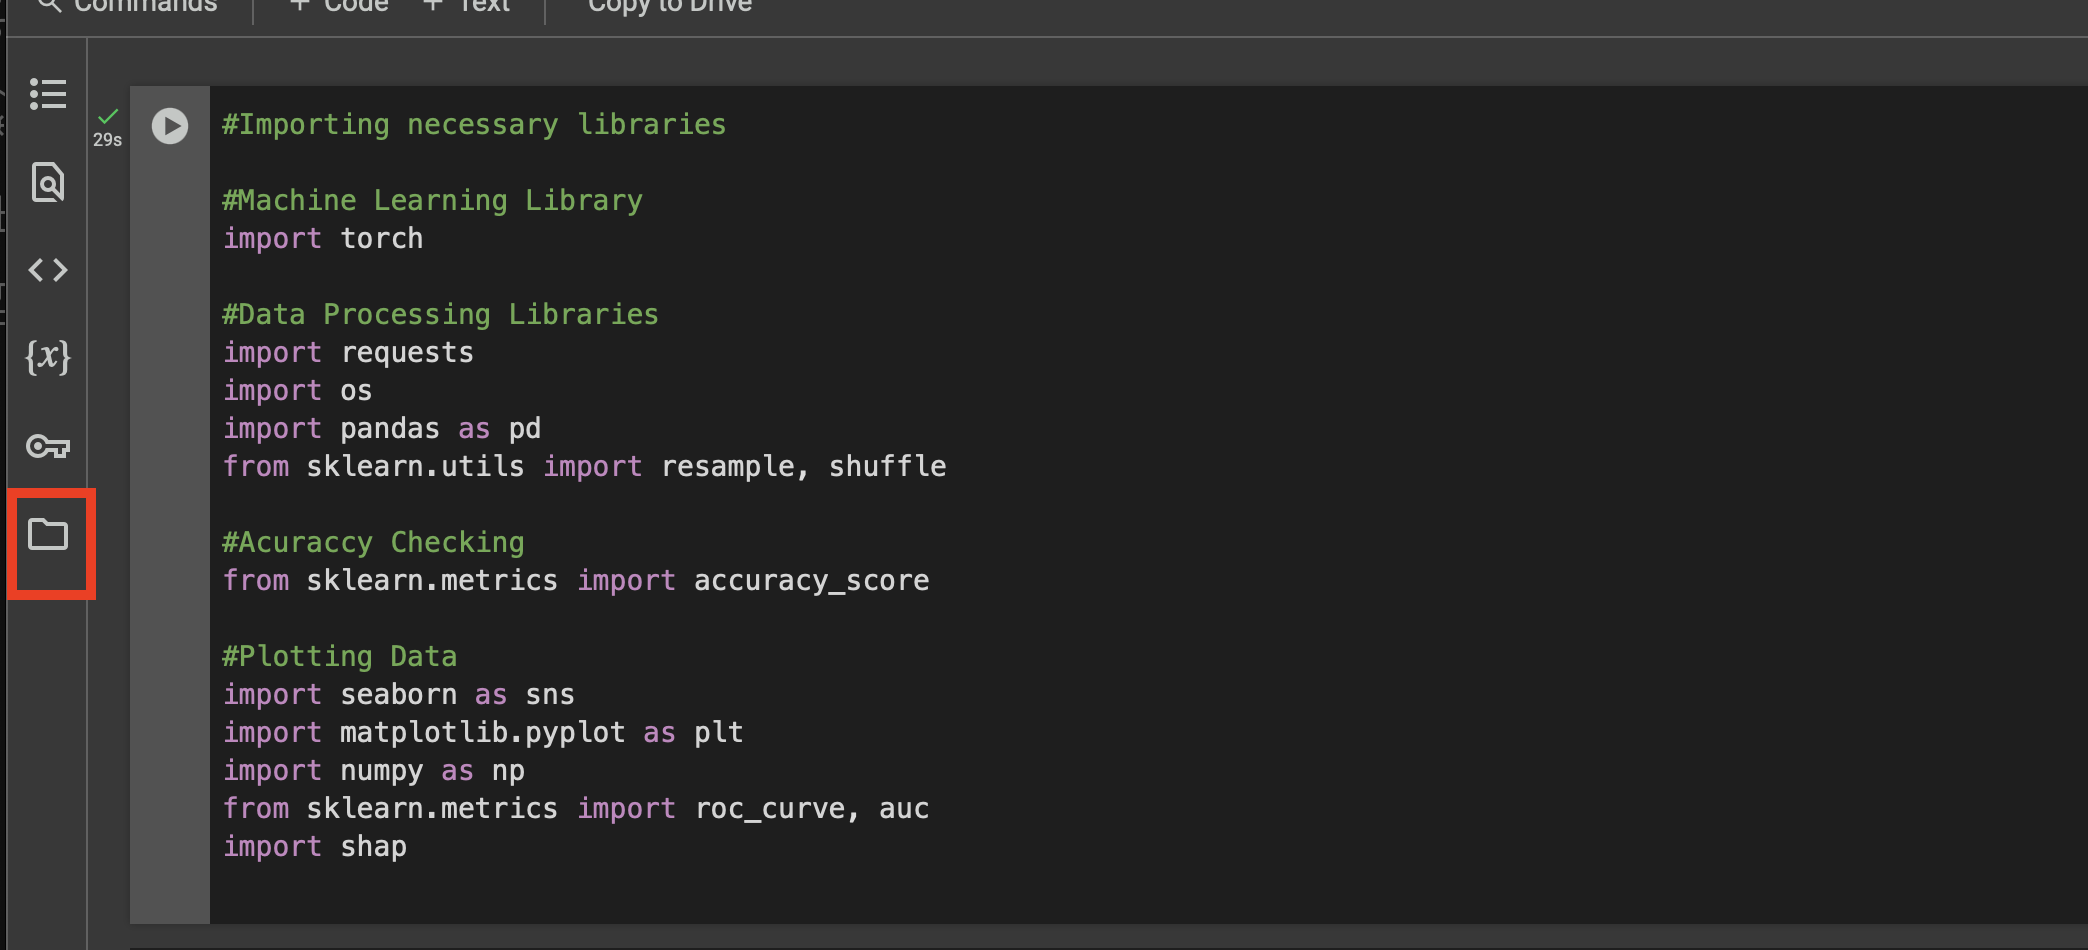

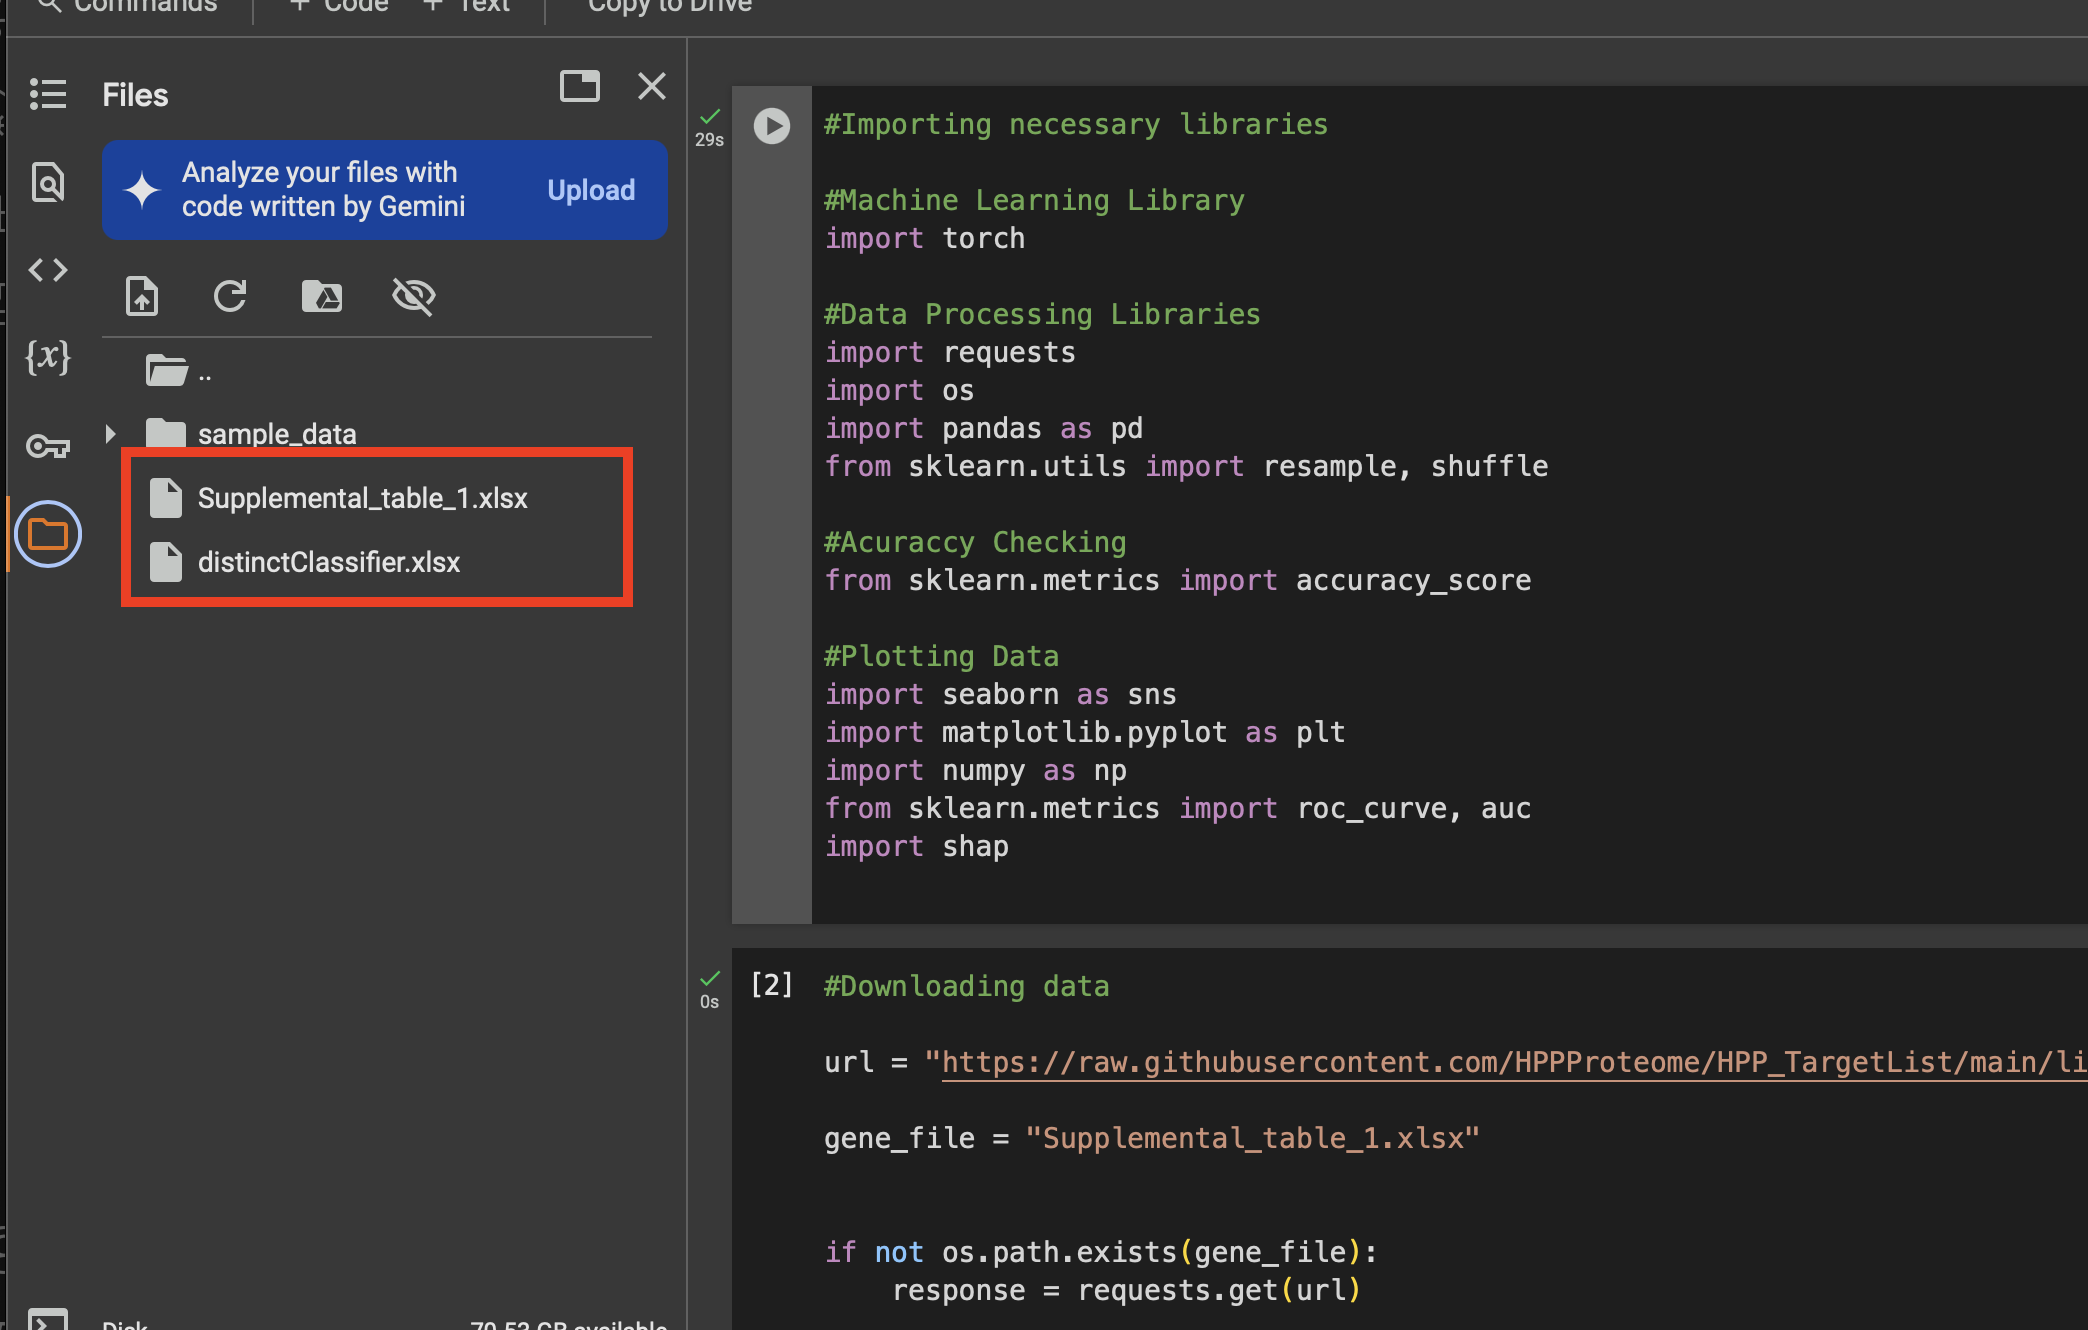

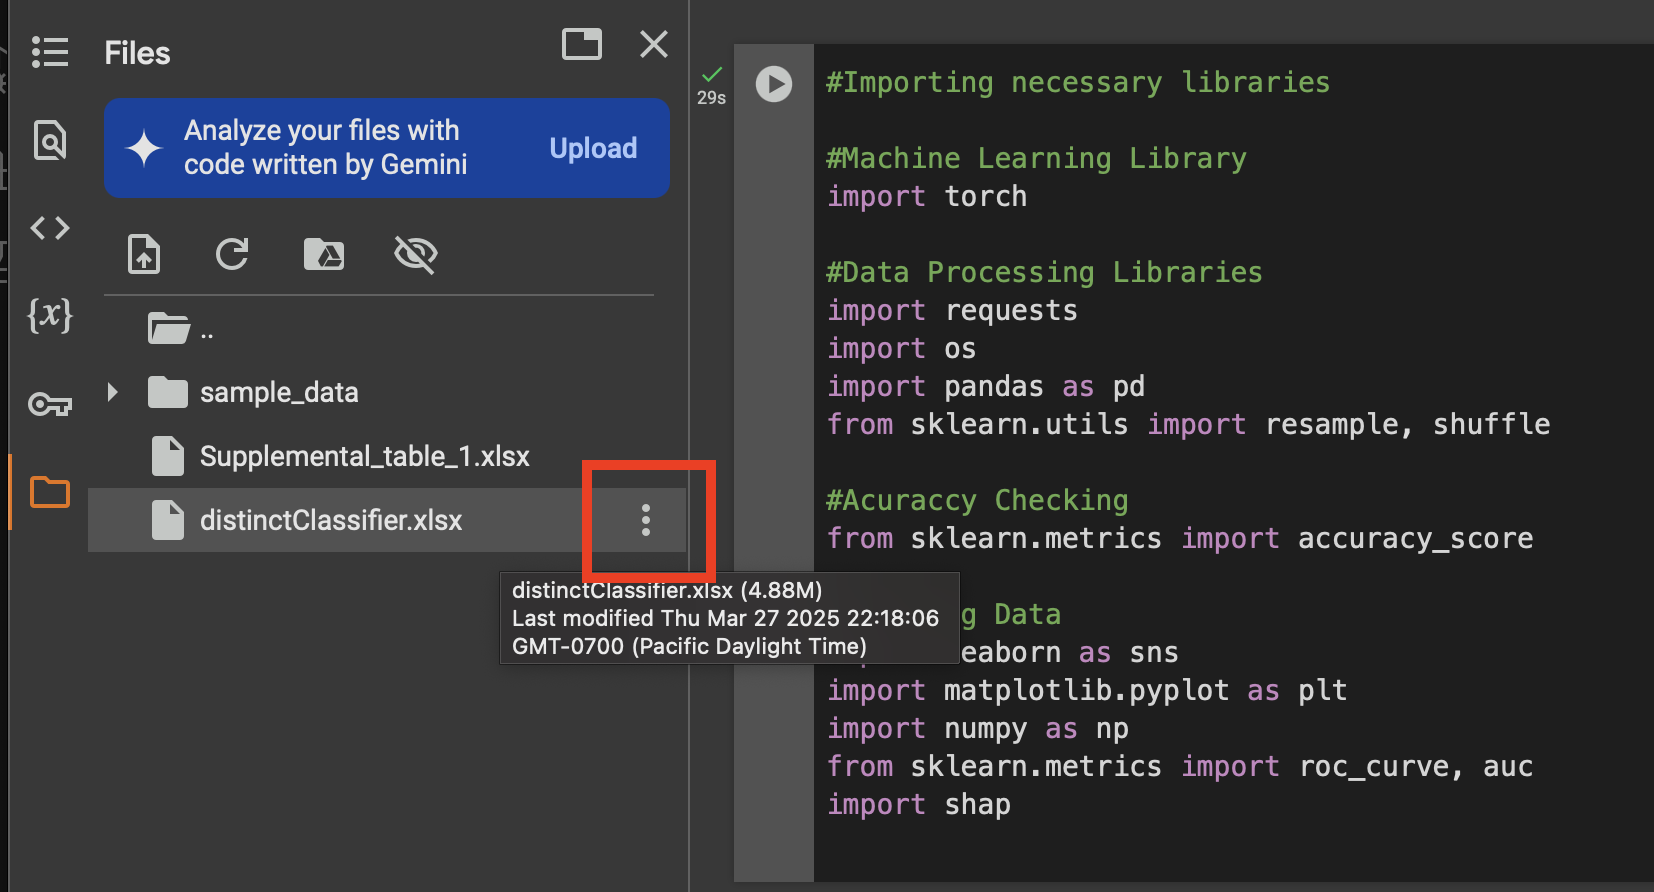

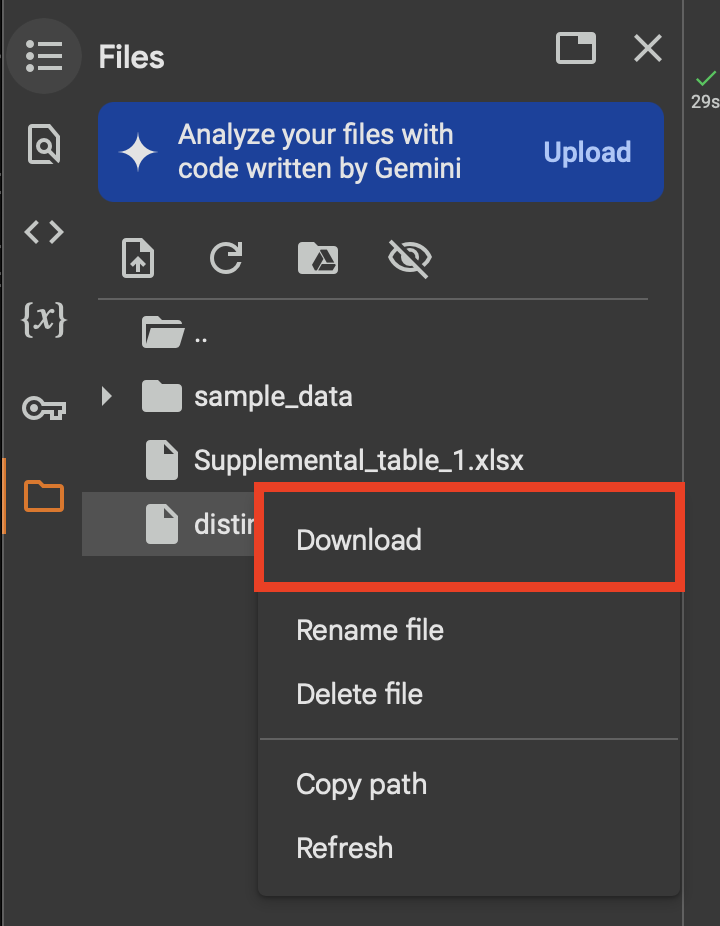

